Checking the CI hull for a gaussian vp.

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import scipy.stats as scs
import scipy.integrate as integrate
from shapely.geometry import Point # used within the ConcaveHull object and to get points out of the hull
from shapely.geometry import LineString # used within the ConcaveHull object
from shapely.geometry import Polygon # used within the ConcaveHull object and to make the polygon to get the points out of the hull

import random # to get points out of the hull

# from matplotlib.path import Path # unsure if this is needed
from numpy import asarray, concatenate, ones
import matplotlib.patches as patches # to make the polygon


import matplotlib.path as mplPath
import time


In [2]:
m = 1
alpha = 1
L = 1
A = 0.6
B = 10
phi0 = 0
sigma = 0.05
phi = np.arange(0,4* 2*np.pi,0.01)

# r_true = two_body_analytic_sol(phi,A,B,phi0)

def two_body_analytic_sol(phi,A,B,phi0 = 0):
    return 1 / (B + A * np.cos(phi - phi0))

def two_body_log_likelihood(theta):
    A, B = theta
    sol = two_body_analytic_sol(phi,A,B,phi0)
    return np.sum(np.log(1/(sigma * (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol - r_true)**2)

r_true = two_body_analytic_sol(phi,A,B,phi0)

D = 2
LB = np.full((1, D), 0.001)  # Lower bounds
UB = np.full((1, D), 100.0)  # Upper bounds
LB[0][0] = 0.0
LB[0][1] = 1.0
UB[0][0] = 0.99

PUB = np.copy(UB) 
PUB[0][0] = 0.9
PUB[0][1] = 30.0
PLB = np.copy(LB)
PLB[0][0] = 0.1
PLB[0][1] = 2.0

x0 = 3 * np.ones((1, D))
x0[0][0] = 0.4
#prior = SplineTrapezoidal(LB, PLB, PUB, UB)
print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0)

LB: [[0. 1.]] PLB: [[0.1 2. ]] PUB: [[ 0.9 30. ]] UB: [[  0.99 100.  ]] x0: [[0.4 3. ]]


In [3]:
vbmc = VBMC(two_body_log_likelihood, x0, LB, UB, PLB, PUB, prior = SplineTrapezoidal(LB, PLB, PUB, UB) ) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        5413.33      1072.60 1624582444713.54        2        inf     start warm-up
     1         15        5213.84         0.84        46.55        2        inf     
     2         20        5214.62         0.08         1.05        2       27.1     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


     3         25        5214.63         0.07         0.01        2      0.427     
     4         30        5214.64         0.05         0.03        2      0.789     
     5         35        5214.58         0.01         0.04        2       1.09     
     6         40        5214.58         0.00         0.00        2     0.0967     
     7         45        5214.57         0.00         0.02        2       0.59     end warm-up


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


     8         50        5214.58         0.00         0.02        2      0.543     
     9         55        5214.55         0.00         0.01        2      0.354     
    10         60        5214.57         0.00         0.00        5      0.144     
    11         65        5214.58         0.00         0.01        8       0.17     rotoscale, undo rotoscale
    12         70        5214.58         0.00         0.00       11      0.074     
    13         75        5214.44         0.00         0.03       11       1.23     
    14         80        5214.57         0.00         0.04       11       1.26     
    15         85        5214.53         0.00         0.01       11      0.405     
    16         90        5214.53         0.00         0.08       11       1.87     
    17         95        5214.50         0.00         0.10       11       2.38     
    18        100        5214.56         0.00         0.03       11      0.887     
    19        105        5214.55         0.00      

[[ 0.599125   10.01569282]]


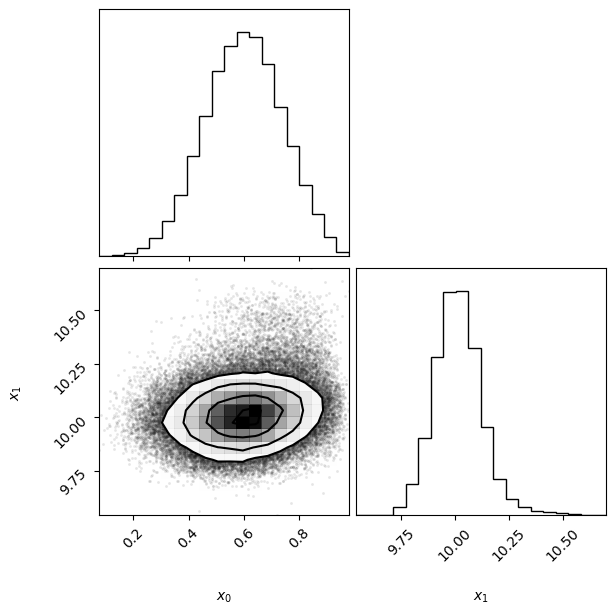

In [4]:
vp.plot();
print(vp.moments())

In [5]:
def samples_above_threshold(vp, true_value, n_samples): # wrap in a while loop
    threshold = vp.pdf(true_value) # find the pdf of our true value
    Xs, _ = vp.sample(n_samples) # get samples out of the distribution
    pdfs = vp.pdf(Xs) # find the pdf of each of those samples

    high_threshold_samples = []
    count = 0
    for i in range(len(pdfs)): # if the pdf is larger than the threshold, the point gets added to high_threshold_samples
        count += 1
        if pdfs[i] >= threshold:
            high_threshold_samples.append(Xs[i])
        # if count == 2000:
        #     return np.array(high_threshold_samples)

    return np.array(high_threshold_samples)

[10.9415035]
1462


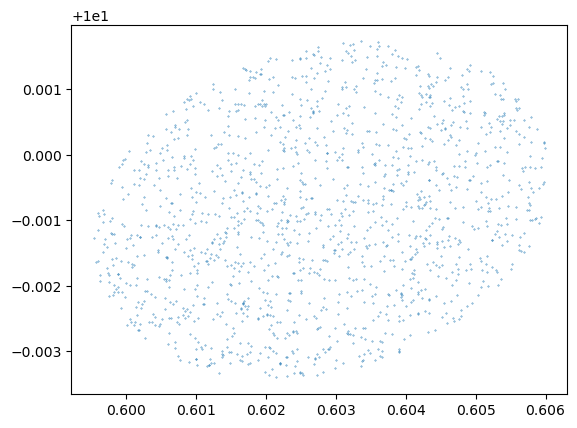

In [16]:
print(vp.pdf([0.6,10.0]))
threshold_samples__ = samples_above_threshold(vp, [0.6,10.0], int(5e6))
print(len(threshold_samples__))
plt.scatter(threshold_samples__[:,0], threshold_samples__[:,1], s=.1)

In [6]:
class ConcaveHull(object):

    def __init__(self, points, k):
        if isinstance(points, np.core.ndarray):
            self.data_set = points
        elif isinstance(points, list):
            self.data_set = np.array(points)
        else:
            raise ValueError('Please provide an [N,2] numpy array or a list of lists.')

        # Clean up duplicates
        self.data_set = np.unique(self.data_set, axis=0)

        # Create the initial index
        self.indices = np.ones(self.data_set.shape[0], dtype=bool)  # bool of a column of all 1's

        self.k = k

    @staticmethod
    def dist_pt_to_group(a, b):  # a is a (n,2) , b is (1,2) arrays
        d = np.sqrt(np.sum(np.square(np.subtract(a, b)), axis=1))
        return d

    @staticmethod
    def get_lowest_latitude_index(points):
        indices = np.argsort(points[:, 1])
        return indices[0]

    @staticmethod
    def norm_array(v):  # normalize row vectors in an array. observations are rows
        norms = np.array(np.sqrt(np.sum(np.square(v), axis=1)), ndmin=2).transpose()
        return np.divide(v, norms)

    @staticmethod
    def norm(v):  # normalize a single vector, is there an existing command?
        norms = np.array(np.sqrt(np.sum(np.square(v))))
        return v / norms

    def get_k_nearest(self, ix, k):
        """
        Calculates the k nearest point indices to the point indexed by ix
        :param ix: Index of the starting point
        :param k: Number of neighbors to consider
        :return: Array of indices into the data set array
        """
        ixs = self.indices
        # base_indices is list of linear indicies that are TRUE, ie part of dataset
        base_indices = np.arange(len(ixs))[ixs]
        distances = self.dist_pt_to_group(self.data_set[ixs, :], self.data_set[ix, :])
        sorted_indices = np.argsort(distances)

        kk = min(k, len(sorted_indices))
        k_nearest = sorted_indices[range(kk)]
        return base_indices[k_nearest]

    def clockwise_angles(self, last, ix, ixs, first):  # last needs to be the index of the previous current point
        if first == 1:
            last_norm = np.array([-1, 0], ndmin=2)
        elif first == 0:
            last_norm = self.norm(np.subtract(self.data_set[last, :], self.data_set[ix,:]))  # normalized vector pointing towards previous point
        ixs_norm = self.norm_array(np.subtract(self.data_set[ixs, :], self.data_set[ix,:]))  # normalized row vectors pointing to set of k nearest neibs
        ang = np.zeros((ixs.shape[0], 1))
        for j in range(ixs.shape[0]):
            theta = np.arccos(np.dot(last_norm, ixs_norm[j, :]))
            # ang[j,0] = theta
            z_comp = np.cross(last_norm, ixs_norm[j, :])
            # ang[j,2] = z
            if z_comp <= 0:
                ang[j, 0] = theta
            elif z_comp > 0:
                ang[j, 0] = 2 * np.pi - theta
        return np.squeeze(ang)

    def recurse_calculate(self):
        """
        Calculates the concave hull using the next value for k while reusing the distances dictionary
        :return: Concave hull
        """
        recurse = ConcaveHull(self.data_set, self.k + 1)
        if recurse.k >= self.data_set.shape[0]:
            print(" max k reached, at k={0}".format(recurse.k))
            return None
        print("k={0}".format(recurse.k))
        return recurse.calculate()

    def calculate(self):
        """
        Calculates the convex hull of the data set as an array of points
        :return: Array of points (N, 2) with the concave hull of the data set
        """
        if self.data_set.shape[0] < 3:
            return None

        if self.data_set.shape[0] == 3:
            return self.data_set

        # Make sure that k neighbors can be found
        kk = min(self.k, self.data_set.shape[0])

        first_point = self.get_lowest_latitude_index(self.data_set)
        current_point = first_point
        # last_point = current_point # not sure if this is necessary since it wont get used until after step 2

        # Note that hull and test_hull are matrices (N, 2)
        hull = np.reshape(np.array(self.data_set[first_point, :]), (1, 2))
        test_hull = hull

        # Remove the first point
        self.indices[first_point] = False

        step = 2
        stop = 2 + kk

        while ((current_point != first_point) or (step == 2)) and len(self.indices[self.indices]) > 0:  # last condition counts number of ones, points in dataset
            if step == stop:
                self.indices[first_point] = True
            # notice how get_k_nearest doesnt take the data set directly as an arg, as it is implicit that it takes self as an imput because we are inside a class:
            knn = self.get_k_nearest(current_point, kk)  # knn = [3,6,2] or [0,2,7] etc indicies into the full dataset (with no points removed)

            if step == 2:
                angles = self.clockwise_angles(1, current_point, knn, 1)
            else:
                # Calculates the headings between first_point and the knn points
                # Returns angles in the same indexing sequence as in knn
                angles = self.clockwise_angles(last_point, current_point, knn, 0)

            # Calculate the candidate indexes (largest angles first). candidates =[0,1,2]  or [2,1,0] etc if kk=3
            candidates = np.argsort(-angles)

            i = 0
            invalid_hull = True

            while invalid_hull and i < len(candidates):
                candidate = candidates[i]

                # Create a test hull to check if there are any self-intersections
                next_point = np.reshape(self.data_set[knn[candidate], :], (1, 2))
                test_hull = np.append(hull, next_point, axis=0)

                line = LineString(test_hull)
                invalid_hull = not line.is_simple  # invalid_hull will remain True for every candidate which creates a line that intersects the hull. as soon as the hull doesnt self intersect, it will become false and the loop will terminate
                i += 1

            if invalid_hull:
                print("invalid hull for all nearest neibs")
                return self.recurse_calculate()

            last_point = current_point  # record last point for clockwise angles
            current_point = knn[candidate] # candidate = 0, 1, or 2 if kk=3
            hull = test_hull

            self.indices[current_point] = False # we remove the newly found current point from the "mask" indicies so that it wont be passed to get_k_nearest (within the implicit input, self)
            step += 1

        poly = Polygon(hull)

        count = 0
        total = self.data_set.shape[0]
        for ix in range(total):
            pt = Point(self.data_set[ix, :])
            if poly.intersects(pt) or pt.within(poly):
                count += 1
            else:
                print("point not in polygon")

        if count == total:
            return hull
        else:
            return self.recurse_calculate()


In [7]:
def concave_hull_high_threshold_points(points):
    obj = ConcaveHull(points, 10)
    hull = obj.calculate()
    return hull

In [8]:
def generate_random(number, hull):
    # start = time.process_time()
    points = []
    # polygon = patches.Polygon(hull) # using this as our main polygon makes it run in .1s versus 24s
    # polygon2 = Polygon(hull) # same polygon as above, but allows us to take the area easily later
    
    path = mplPath.Path(hull)

    # print('path', time.process_time() - start)

    minx, miny, maxx, maxy = min(hull[:,0]), min(hull[:,1]), max(hull[:,0]), max(hull[:,1])


    while len(points) < number:
        # pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))

        pnt = (random.uniform(minx, maxx), random.uniform(miny, maxy),)
        # pnts = (random.uniform(minx, maxx), random.uniform(miny, maxy),)

        # arry = np.zeros((100,2))
        # arry[:,0] = np.random.uniform(minx, maxx, 100)
        # arry[:,1] = np.random.uniform(miny, maxy, 100)
        

        # start_time = time()
        # path = mpltPath.Path(polygon)
        if path.contains_point(pnt):
            # points.append([pnt.x, pnt.y])
            points.append(pnt)
        # inside2 = path.contains_points(pnt)
        

        # if path.contains_points(arry).all():
        #     print('hit')
        #     points.append(arry[:])

        # if polygon2.contains(pnt):
        #     points.append([pnt.x, pnt.y])
    
    # print('points', time.process_time() - start)
    list_points = np.array(points)

    x, y = hull[:,0], hull[:,1]
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    area = 0.5*np.abs(main_area + correction)

    
    # area = polygon2.area
    # area = (maxx - minx) * (maxy - miny) # apparently this is the correct way to take the data
    return list_points, area

In [9]:
def create_CI(vp, random_pulls):
    points, area = random_pulls[0], random_pulls[1]
    pdfs = vp.pdf(points)
    integral = np.sum(pdfs)/len(pdfs) * area # same as average of pdfs multiplied by the area
    return integral

In [10]:
def create_CI_using_threshold(vp, true_value, n_samples, number):
    # start = time.process_time()
    samples_used = samples_above_threshold(vp, true_value, n_samples)
    # print("samples_used", time.process_time() - start)
    hull =  concave_hull_high_threshold_points(samples_used)
    # print('hull',time.process_time() - start)
    uniform_rand_pnts_in_poly = generate_random(number, hull)
    # print('uniform_rand_pnts_in_poly',time.process_time() - start)
    CI = create_CI(vp, uniform_rand_pnts_in_poly)
    # print('CI',time.process_time() - start)
    return CI

In [11]:
create_CI_using_threshold(vp, [.6,10], int(5e5), int(5e5))

0.00024160087494577834

In [12]:
def get_box(vp,true_value, bounds = False):
    pdf_mean = vp.moments()
    real0 = true_value[0]
    real1 = true_value[1]
    x0 = pdf_mean[0,0]
    x1 = pdf_mean[0,1]
    d0 = abs(x0-real0)
    d1 = abs(x1-real1)
    bl = (x0 - d0, x1 - d1)
    br = (x0 + d0, x1 - d1)
    tl = (x0 - d0, x1 + d1)
    tr = (x0 + d0, x1 + d1)
    if bounds:
        x_lb = x0 - d0
        x_ub = x0 + d0
        y_lb = x1 - d1
        y_ub = x1 + d1
        return x_lb,x_ub, y_lb, y_ub
    else:
        return np.asarray([bl,br,tr,tl,bl])

def CI_2D(vp,pdf,true_value):
    x_lb,x_ub, y_lb, y_ub = get_box(vp,true_value, bounds=True)
    return integrate.dblquad(pdf, x_lb, x_ub, y_lb, y_ub)[0]

In [13]:
pdf= lambda x,y: vp.pdf(np.array([[y,x]]))

CI_2D(vp,pdf,[.6,10])

0.0004597784471862375